<h1>SIMILAR IMAGE RETRIVAL</h1>

In [ ]:
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
from skimage.transform import resize
import os
import skimage.io
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold
import random
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import image
from tqdm import tqdm_notebook
from numpy import load
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.utils.data_utils import get_file
from keras import optimizers, losses
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras

__SEE FEW IMAGES FROM DATASET__

Working with 4738 images
Image examples: 
3422.jpg


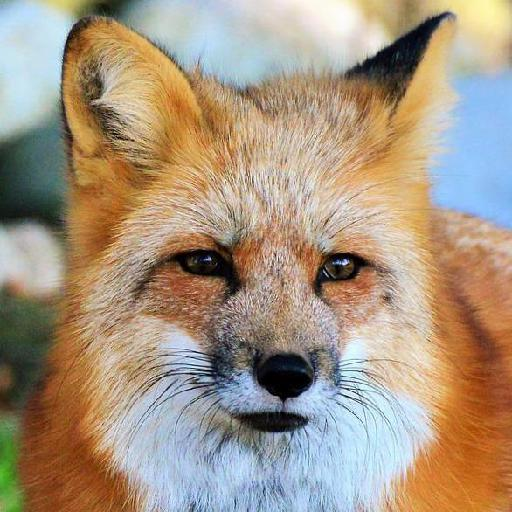

879.jpg


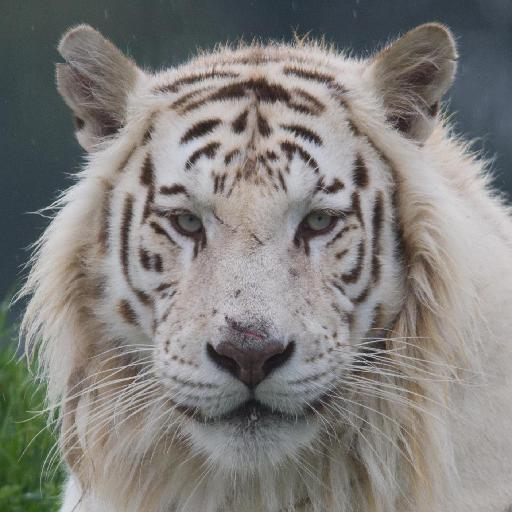

In [ ]:
folder = "dataset"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(32, 34):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=512, height=512))

__PREPROCESSING THE IMAGE IN THE DATASET__

In [ ]:
train_files = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    
print("Files in train_files: %d" % len(train_files))

# Original Dimensions
image_width = 512
image_height = 512
ratio = 2
channel =3
image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
X_train = np.ndarray(shape=(len(train_files),image_height, image_width,channel),
                     dtype=np.float32)

i = 0
for _file in tqdm_notebook((train_files)):
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((256, 256,3))
    # Normalize
    x = x / 255
    X_train[i] = x
    i += 1
print("All images to array!")

Files in train_files: 4738


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



All images to array!


#WARNING I HAVE 32 GB OF RAM CONVERTING ALL THE 5k IMAGES TO ARRAY REQUIRES LOTS OF RAM SO I CONVERTED AND SAVE it IN My drive for further use##

In [ ]:
from numpy import save

In [ ]:
save('compress_image.npz',X_train)

In [ ]:
X_train.shape

(4738, 256, 256, 3)

In [ ]:
IMG_SHAPE = X_train.shape[1:]

<h2>BUILDING AUTO ENCODER</h2>

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size)) 
#     encoder.summary()

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(16*16*256))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape((16,16,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

__ABOVE I HAVE CONFIGURE MY DEEP AUTO ENCODER__

In [ ]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=256)
encoder.summary()
decoder.summary()
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [ ]:
inp = L.Input(IMG_SHAPE)#input is image of shape(len(data)*width*height*channe)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

__MY TASK IS NOT TO PREDICT ANY THING SO I PASSED BOTH X_train in x and y__

In [ ]:
autoencoder.fit(x=X_train, y=X_train, epochs=100,
                validation_split=0.05,
                verbose=1)

Epoch 1/100
141/141 [==============================] - 11s 77ms/step - loss: 0.0546 - val_loss: 0.0343
Epoch 2/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0317 - val_loss: 0.0295
Epoch 3/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0279 - val_loss: 0.0262
Epoch 4/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0251 - val_loss: 0.0243
Epoch 5/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0231 - val_loss: 0.0221
Epoch 6/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 7/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0200 - val_loss: 0.0191
Epoch 8/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 9/100
141/141 [==============================] - 10s 72ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 10/100
141/141 [==============================] - 10s 72ms/step - l

__I ONLY WANT MY ENCODER PART BECAUSE IT CONVERTS IMAGE FEATURE INTO SINGLE ARRAY SO I WANT THAT onlY AFTER TRAINInG__

In [ ]:
codes = encoder.predict(X_train)

__SO WHAT I GONNA DO IS PREDICT the feature of all the images and compare it with the given image and if we find the similar feature with any of the images in the dataset we simply return it.__

In [ ]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="cosine",n_neighbors=10)
nei_clf.fit(codes)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

__trained nearest neighbour with the feature of the images in the given dataset__

In [ ]:
def get_similar(image, n_neighbors):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)# predict the nearest neighbors of the query image
    
    return distances,images[idx]

In [ ]:
def show_similar(image,n_neighbors):
    
    distances,neighbors = get_similar(image,n_neighbors)
    w=10
    h=10
    print("Original Image")
    plt.imshow(image)
    fig=plt.figure(figsize=(16, 16))
    columns = 4
    rows = 5
    for i in range(1, n_neighbors):
      fig.add_subplot(rows, columns, i)
      plt.imshow(neighbors[i])
      plt.title("Dist=%.3f"%distances[i])

Original Image


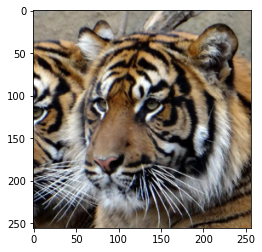

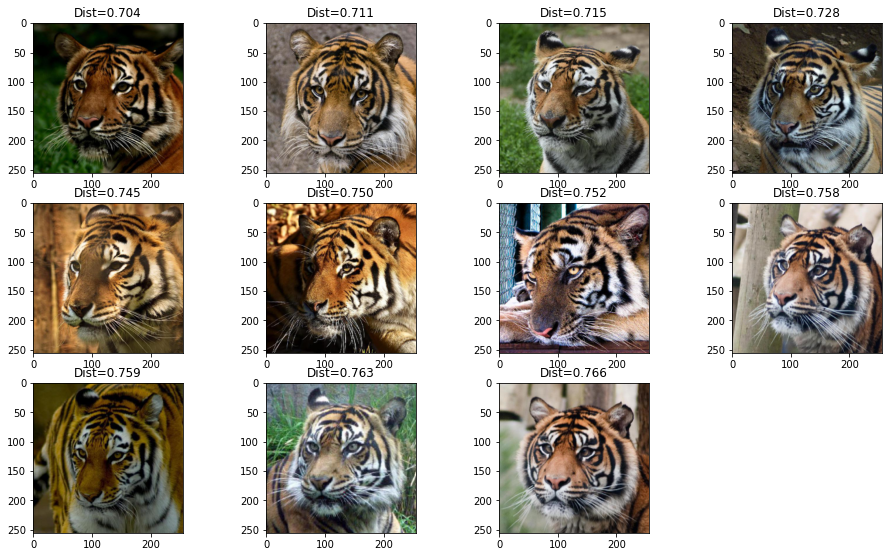

In [ ]:
show_similar(X_train[88],12)

__YOU CAN SEE THE RESULT FROM THE ABOVE PLOTS__

<h1>CLUSTERING THE provided dataset  into K groups</h1>

STEPS:<br>
1. Pass the single dimension vector from the above model <br>
2. Apply k-mean on the feature and find optimal k with Elbow method<br>
3. after finding optimal k apply kmean on dataset <br> 
4. divide the dataset into k cluster

In [ ]:
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook

In [ ]:
cost =[] 
for i in tqdm_notebook(range(1,11)): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(codes) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


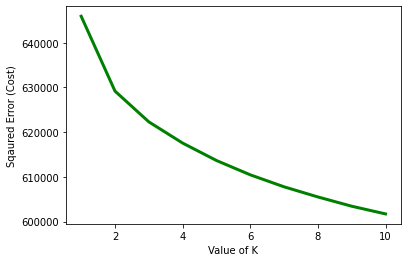

In [ ]:
plt.plot(range(1,11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot 

In [ ]:
k = 4
kmodel = KMeans(n_clusters=k, n_jobs=-1, max_iter=500)
kmodel.fit(codes)
kpredictions = kmodel.predict(codes)

In [ ]:
c = {'ani1':[],'ani2':[],'ani3':[],'ani4':[]}

In [ ]:
for i in range(len(kpredictions)):
  if kpredictions[i] == 0:
    c['ani1'].append(i)
  elif kpredictions[i] == 1:
    c['ani2'].append(i)
  elif kpredictions[i] == 2:
    c['ani3'].append(i)
  elif kpredictions[i] == 3:
    c['ani4'].append(i)

In [ ]:
import random

In [ ]:
def show_cluster_images(animal_index_list,i,p):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 4
    fig.text(1,1,p)
    for i in range(1, 9):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[animal_index_list[random.randint(0, len(animal_index_list))]])


In [ ]:
def show_cluster(c):
  j=0
  for i in c:
    show_cluster_images(c[i],i,p[j])
    j=j+1

In [ ]:
p = ['Lion','Leopard','Tiger','Wolf/Fox/mostly white animals']

__I HAVE GIVEN NAME BY RUNNING MANY TIMES MOST OF IMAGES ARE CORRECT__

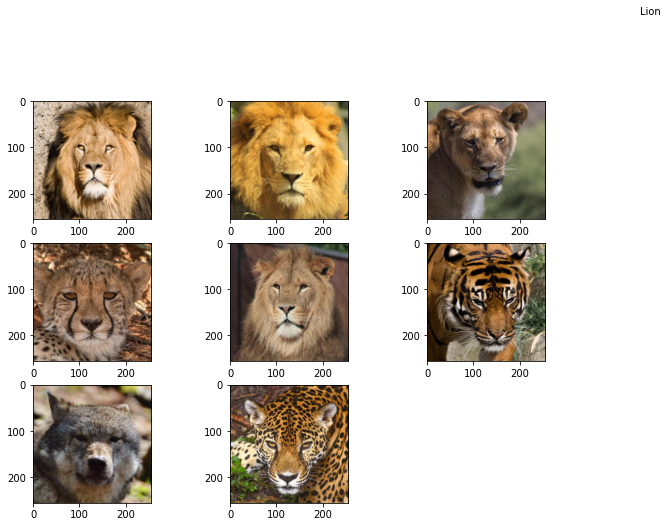

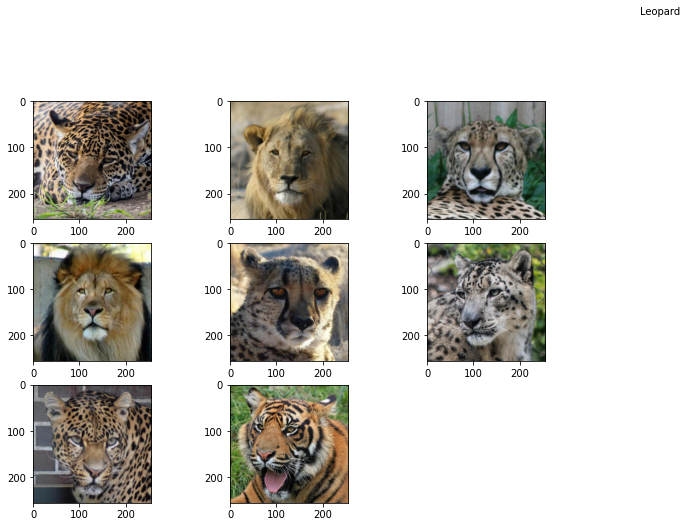

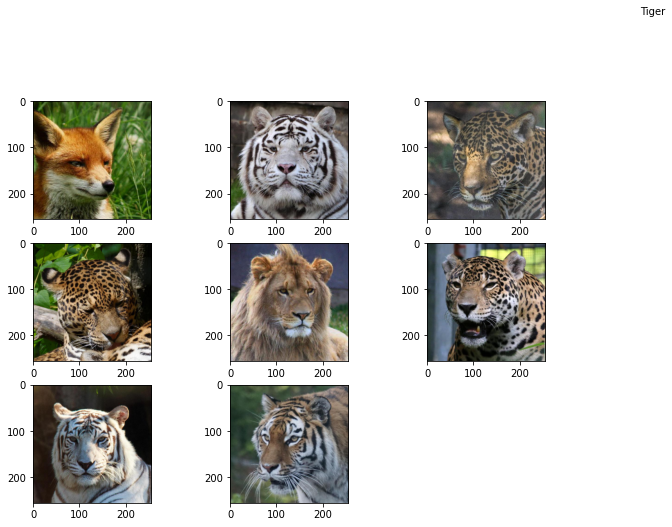

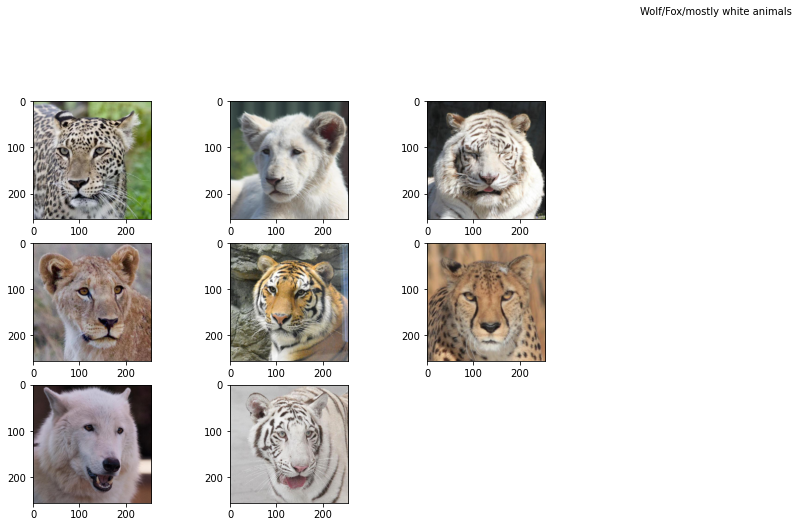

In [ ]:
show_cluster(c)

__FOR TESTING PURPOSE I HAVE CREATED SEPERATE IPYNP YOU CAN TEST THERE__
https://colab.research.google.com/drive/1kBvr3afpMMhkETIXB9-3HvipeplKKsYm?usp=sharing<br>

go to this link

__I THINK MY RESULT ARE NOT BAD AS I TRAINED USING MY OWN MODEL IF I USED ANY PRETRAINED MODEL RESULT CAN BE VERY DESCENT__

__END__